In [25]:
!pip install pytorch-fid


## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import librosa
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import io
from keras.layers import Dense, Input, Flatten, LeakyReLU, Reshape, Dropout
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, UpSampling2D, Conv2D, BatchNormalization, Reshape, Conv2DTranspose, ReLU
from keras.models import Model, Sequential
import tensorflow as tf
import re
import unicodedata
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch.optim as optim
from transformers import BertModel
import torch
from tensorflow.keras.datasets import mnist

## Preprocess MNIST

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


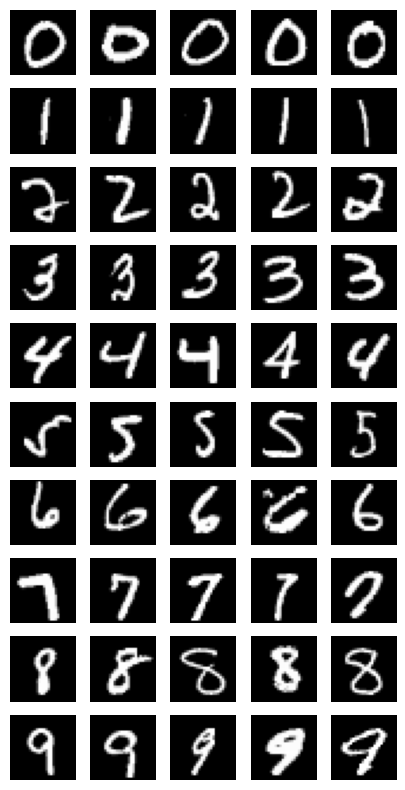

In [ ]:
num_classes = 10

def plot_images_per_class(images, labels, num_samples=5):
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples, num_classes))

    for class_label in range(num_classes):
        class_indices = np.where(labels == class_label)[0]
        random_indices = np.random.choice(class_indices, num_samples, replace=False)

        for i, index in enumerate(random_indices):
            axes[class_label, i].imshow(images[index], cmap='gray')
            axes[class_label, i].axis('off')

    plt.show()

plot_images_per_class(train_images, train_labels)


In [ ]:
X = np.vstack((train_images,test_images))
X = X.astype('float32')
X = X / 255.0
X = X.reshape((X.shape[0], 28, 28, 1))
X = X.reshape((X.shape[0], 1, 28, 28))

In [ ]:
X.shape

(70000, 1, 28, 28)

## 2-1. GAN on MNIST

## 2-3. Self Supervised GAN

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
from typing import Sequence

import os.path
import tarfile, sys, math
from six.moves import urllib

import numpy as np
import scipy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.autograd import grad as torch_grad


In [3]:
def get_mnist_dataloaders(batch_size=128):
    all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    train_data = datasets.MNIST('../data', train=True, download=True,
                                transform=all_transforms)
    test_data = datasets.MNIST('../data', train=False,
                               transform=all_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [4]:
class SpectralNorm:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        u = getattr(module, self.name + '_u')
        size = weight.size()
        weight_mat = weight.contiguous().view(size[0], -1)
        if weight_mat.is_cuda:
            u = u.cuda()
        v = weight_mat.t() @ u
        v = v / v.norm()
        u = weight_mat @ v
        u = u / u.norm()
        weight_sn = weight_mat / (u.t() @ weight_mat @ v)
        weight_sn = weight_sn.view(*size)

        return weight_sn, Variable(u.data)

    @staticmethod
    def apply(module, name):
        fn = SpectralNorm(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        input_size = weight.size(0)
        u = Variable(torch.randn(input_size, 1) * 0.1, requires_grad=False)
        setattr(module, name + '_u', u)
        setattr(module, name, fn.compute_weight(module)[0])

        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight_sn, u = self.compute_weight(module)
        setattr(module, self.name, weight_sn)
        setattr(module, self.name + '_u', u)

def spectral_norm(module, name='weight'):
    SpectralNorm.apply(module, name)

    return module


def log_sum_exp(x, axis = 1):
    m = torch.max(x, keepdim = True)
    return m + torch.logsumexp(x - m, dim = 1, keepdim = True)


class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, padding, kernel_size = 4, stride = 2,
                spectral_normed = False):
        super(conv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                                padding = padding)
        if spectral_normed:
            self.conv = spectral_norm(self.conv)

    def forward(self, input):
        out = self.conv(input)
        return out


class deconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, padding, kernel_size = (4,4), stride = (2,2),
                spectral_normed = False, iter = 1):
        super(deconv2d, self).__init__()

        self.devconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                        stride, padding = padding)
        if spectral_normed:
            self.devconv = spectral_norm(self.deconv)

    def forward(self, input):
        out = self.devconv(input)
        return out


def conv_cond_concat(x, y):
    x_shapes = list(x.size())
    y_shapes = list(y.size())
    return torch.cat((x,y*torch,ones(x_shapes[0],x_shapes[1],x_shapes[2],y_shapes[3])))


class Residual_G(nn.Module):
    def __init__(self, in_channels, out_channels = 256, kernel_size = 3, stride = 1,
                spectral_normed = False, up_sampling = False):
        super(Residual_G, self).__init__()
        self.up_sampling = up_sampling
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.conv1 = conv2d(in_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel_size, stride = stride, padding = 1)
        self.conv2 = conv2d(out_channels, out_channels, spectral_normed= spectral_normed,
                            kernel_size = kernel_size, stride = stride, padding = 1)

    def forward(self, x):
        input = x
        x = self.relu(self.batch_norm1(x))
        if self.up_sampling:
            x = self.upsample(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.conv2(self.relu(x))
        if self.up_sampling:
            return self.upsample(input) + x
        else:
            return input + x


class Residual_D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel = 3, stride = 1,
                spectral_normed = False, down_sampling = False, is_start = False):
        super(Residual_D, self).__init__()
        self.down_sampling = down_sampling
        self.is_start = is_start

        self.avgpool_short = nn.AvgPool2d(2, 2, padding = 1)
        self.conv_short = conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                spectral_normed = False)
        self.conv1 = conv2d(in_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel, stride = stride, padding = 1)
        self.conv2 = conv2d(out_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel, stride = stride, padding = 1)
        self.avgpool2 = nn.AvgPool2d(2, 2, padding = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        input = x
        if self.is_start:
            conv1 = self.relu(self.conv1(x))
            conv2 = self.relu(self.conv2(conv1))
            if self.down_sampling:
                conv2 = self.avgpool2(conv2)
        else:
            conv1 = self.conv1(self.relu(x))
            conv2 = self.conv2(self.relu(conv1))
            if self.down_sampling:
                conv2 = self.avgpool2(conv2)

        if self.down_sampling:
            input = self.avgpool_short(input)
        resi = self.conv_short(input)

        return resi + conv2

In [5]:
class Generator(nn.Module):
    def __init__(self, z_size, channel, resnet = False, output_size = 32):
        super(Generator, self).__init__()
        s = 4
        self.output_size = output_size
        if self.output_size == 32:
            s = 4
        if self.output_size == 48:
            s = 6
        self.s = s
        self.z_size = z_size
        self.resnet = resnet
        self.fully_connect = nn.Linear(z_size, s*s*256)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.deconv1 = deconv2d(256, 256, padding = 0)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv2 = deconv2d(256, 128, padding = 0)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = deconv2d(128, 64, padding = 0)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = conv2d(64, channel, padding = 1, kernel_size = 3, stride = 1)
        self.conv_res4 = conv2d(256,channel, padding = 1, kernel_size = 3, stride = 1)

        self.re1 = Residual_G(256, 256, up_sampling = True)
        self.re2 = Residual_G(256, 256, up_sampling = True)
        self.re3 = Residual_G(256, 256, up_sampling = True)
        self.bn = nn.BatchNorm2d(256)

    def forward(self, x):
        d1 = self.fully_connect(x)
        d1 = d1.view(-1, 256, self.s, self.s)
        if self.resnet == False:
            d1 = self.relu(d1)
            d2 = self.relu(self.bn1(self.deconv1(d1)))
            d3 = self.relu(self.bn2(self.deconv2(d2)))
            d4 = self.relu(self.bn3(self.deconv3(d3)))
            d5 = self.conv4(d4)
        else:
            d2 = self.re1(d1)
            d3 = self.re2(d2)
            d4 = self.re3(d3)
            d4 = self.relu(self.bn(d4))
            d5 = self.conv_res4(d4)

        return self.tanh(d5)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.z_size))

In [6]:

class Discriminator(nn.Module):
    def __init__(self, spectral_normed, num_rotation,
                ssup, channel, resnet = False):
        super(Discriminator, self).__init__()
        self.resnet = resnet
        self.num_rotation = num_rotation
        self.ssup = ssup

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.conv1 = conv2d(channel, 64, kernel_size = 3, stride = 1, padding = 1,
                            spectral_normed = spectral_normed)
        self.conv2 = conv2d(64, 128, spectral_normed = spectral_normed,
                            padding = 0)
        self.conv3 = conv2d(128, 256, spectral_normed = spectral_normed,
                            padding = 0)
        self.conv4 = conv2d(256, 512, spectral_normed = spectral_normed,
                            padding = 0)
        self.fully_connect_gan1 = nn.Linear(512, 1)
        self.fully_connect_rot1 = nn.Linear(512, 4)
        self.softmax = nn.Softmax()

        self.re1 = Residual_D(channel, 128, spectral_normed = spectral_normed,
                            down_sampling = True, is_start = True)
        self.re2 = Residual_D(128, 128, spectral_normed = spectral_normed,
                            down_sampling = True)
        self.re3 = Residual_D(128, 128, spectral_normed = spectral_normed)
        self.re4 = Residual_D(128, 128, spectral_normed = spectral_normed)
        self.fully_connect_gan2 = nn.Linear(128, 1)
        self.fully_connect_rot2 = nn.Linear(128, 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if self.resnet == False:
            conv1 = self.lrelu(self.conv1(x))
            conv2 = self.lrelu(self.conv2(conv1))
            conv3 = self.lrelu(self.conv3(conv2))
            conv4 = self.lrelu(self.conv4(conv3))
            conv4 = torch.view(conv4.size(0)*self.num_rotation, -1)
            gan_logits = self.fully_connect_gan1(conv4)
            if self.ssup:
                rot_logits = self.fully_connect_rot1(conv4)
                rot_prob = self.softmax(rot_logits)
        else:
            re1 = self.re1(x)
            re2 = self.re2(re1)
            re3 = self.re3(re2)
            re4 = self.re4(re3)
            re4 = self.relu(re4)
            re4 = torch.sum(re4,dim = (2,3))
            gan_logits = self.fully_connect_gan2(re4)
            if self.ssup:
                rot_logits = self.fully_connect_rot2(re4)
                rot_prob = self.softmax(rot_logits)

        if self.ssup:
            return self.sigmoid(gan_logits), gan_logits, rot_logits, rot_prob
        else:
            return self.sigmoid(gan_logits), gan_logits


In [27]:
class Trainer():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 weight_rotation_loss_d, weight_rotation_loss_g, gp_weight=10, critic_iterations=5, print_every=100,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.weight_rotation_loss_d = weight_rotation_loss_d
        self.weight_rotation_loss_g = weight_rotation_loss_g

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data, generated_data, batch_size):

        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        _, d_real_pro_logits, d_real_rot_logits, d_real_rot_prob = self.D(data)
        _, g_fake_pro_logits, g_fake_rot_logits, g_fake_rot_prob = self.D(generated_data)


        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data)

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = torch.sum(g_fake_pro_logits) - torch.sum(d_real_pro_logits) + gradient_penalty

        # Add auxiiary rotation loss
        rot_labels = torch.zeros(4*batch_size).cuda()
        for i in range(4*batch_size):
            if i < batch_size:
                rot_labels[i] = 0
            elif i < 2*batch_size:
                rot_labels[i] = 1
            elif i < 3*batch_size:
                rot_labels[i] = 2
            else:
                rot_labels[i] = 3

        rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
        d_real_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
                                    input = d_real_rot_logits,
                                    target = rot_labels))

        d_loss += self.weight_rotation_loss_d * d_real_class_loss
        d_loss.backward(retain_graph=True)

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data)

    def _generator_train_iteration(self, generated_data, batch_size):
        """ """
        self.G_opt.zero_grad()

        # Calculate loss and optimize
        _, g_fake_pro_logits, g_fake_rot_logits, g_fake_rot_prob = self.D(generated_data)
        g_loss = - torch.sum(g_fake_pro_logits)

        # add auxiliary rotation loss
        rot_labels = torch.zeros(4*batch_size,).cuda()
        for i in range(4*batch_size):
            if i < batch_size:
                rot_labels[i] = 0
            elif i < 2*batch_size:
                rot_labels[i] = 1
            elif i < 3*batch_size:
                rot_labels[i] = 2
            else:
                rot_labels[i] = 3

        rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
        g_fake_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
            input = g_fake_rot_logits,
            target = rot_labels))


        g_loss += self.weight_rotation_loss_g * g_fake_class_loss

        g_loss.backward(retain_graph=True)
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.data)

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        _, prob_interpolated, _, _ = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).sum().data)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader):
        for i, data in enumerate(data_loader):
            # Get generated data
            data = data[0]
            batch_size = data.size()[0]
            generated_data = self.sample_generator(batch_size)

            x = generated_data
            x_90 = x.transpose(2,3)
            x_180 = x.flip(2,3)
            x_270 = x.transpose(2,3).flip(2,3)
            generated_data = torch.cat((x, x_90, x_180, x_270),0)

            x = data
            x_90 = x.transpose(2,3)
            x_180 = x.flip(2,3)
            x_270 = x.transpose(2,3).flip(2,3)
            data = torch.cat((x,x_90,x_180,x_270),0)

            self.num_steps += 1
            self._critic_train_iteration(data, generated_data, batch_size)
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(generated_data, batch_size)

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))

    def train(self, data_loader, epochs, save_training_gif=True):
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)
    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

Iterations per Epoch=
Batch Size /
Dataset Size

60.000 / batch_size
​


In [17]:
data_loader, _ = get_mnist_dataloaders(batch_size=64)
img_size = (32, 32, 1)

generator = Generator(resnet = True, z_size = 128, channel = 1)
discriminator = Discriminator(resnet = True, spectral_normed = True, num_rotation = 4,
				 channel = 1, ssup = True)


# Initialize optimizers
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=betas)

# Train model
epochs = 2
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  weight_rotation_loss_d = 1.0, weight_rotation_loss_g = 0.5,
                  use_cuda=torch.cuda.is_available())
trainer.train(data_loader, epochs, save_training_gif=False)


Epoch 1
Iteration 1
D: -36.382835388183594
GP: 8.316668510437012
Gradient norm: 22.544193267822266
Iteration 101
D: -60550.84375
GP: 102037.0390625
Gradient norm: 25466.06640625
G: -2216190.75
Iteration 201
D: -66118.640625
GP: 56976.125
Gradient norm: 19501.6640625
G: -2111852.25
Iteration 301
D: -40529.6171875
GP: 35261.97265625
Gradient norm: 15417.015625
G: -3379698.0
Iteration 401
D: -28117.55078125
GP: 27484.748046875
Gradient norm: 13648.7158203125
G: -3079845.75
Iteration 501
D: -14408.564453125
GP: 13208.8291015625
Gradient norm: 9548.845703125
G: -2077183.25
Iteration 601
D: -13855.03515625
GP: 9500.89453125
Gradient norm: 8138.146484375
G: -1808193.125
Iteration 701
D: -8622.513671875
GP: 7681.5673828125
Gradient norm: 7342.0234375
G: -1837473.5
Iteration 801
D: -8537.6513671875
GP: 6873.8505859375
Gradient norm: 6958.150390625
G: -2220760.0
Iteration 901
D: -4337.1865234375
GP: 5677.21923828125
Gradient norm: 6338.64501953125
G: -1835098.75

Epoch 2
Iteration 1
D: -8381.56

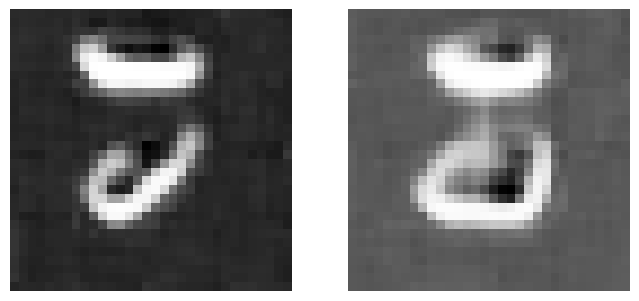

In [22]:
import matplotlib.pyplot as plt

# Number of images to generate
num_generated_images = 2

# Generate images using the trained model
latent_samples = Variable(trainer.G.sample_latent(num_generated_images))
if trainer.use_cuda:
    latent_samples = latent_samples.cuda()

generated_data = trainer.G(latent_samples)

# Remove the extra dimension and convert to numpy array
generated_images = generated_data[:, 0, :, :].data.cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(1, num_generated_images, figsize=(8, 4))

for i in range(num_generated_images):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()


In [29]:
# Continue training for additional epochs
additional_epochs = 2
trainer.train(data_loader, additional_epochs, save_training_gif=False)



Epoch 1
Iteration 1
D: -3615.790283203125
GP: 3977.400390625
Gradient norm: 5349.828125
G: -1219930.375
Iteration 101
D: -3383.27001953125
GP: 3877.387939453125
Gradient norm: 5287.6728515625
G: -1048026.4375
Iteration 201
D: -3481.99755859375
GP: 4231.73876953125
Gradient norm: 5503.70703125
G: -1188602.0
Iteration 301
D: -4137.31494140625
GP: 2412.3359375
Gradient norm: 4206.9697265625
G: -587725.5
Iteration 401
D: -5012.48583984375
GP: 3260.385498046875
Gradient norm: 4866.048828125
G: -1334317.625
Iteration 501
D: -1056.72265625
GP: 2230.435302734375
Gradient norm: 4062.9150390625
G: -543805.625
Iteration 601
D: -3945.747314453125
GP: 1717.9608154296875
Gradient norm: 3602.4423828125
G: -674156.3125
Iteration 701
D: -2385.1796875
GP: 2210.5078125
Gradient norm: 4044.6728515625
G: -598531.4375
Iteration 801
D: -1922.123291015625
GP: 1439.372802734375
Gradient norm: 3308.81298828125
G: -767914.875
Iteration 901
D: -1179.46435546875
GP: 5018.9248046875
Gradient norm: 5964.30859375
G:

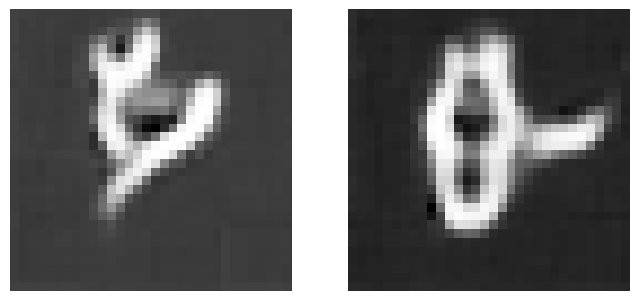

In [30]:
import matplotlib.pyplot as plt

# Number of images to generate
num_generated_images = 2

# Generate images using the trained model
latent_samples = Variable(trainer.G.sample_latent(num_generated_images))
if trainer.use_cuda:
    latent_samples = latent_samples.cuda()

generated_data = trainer.G(latent_samples)

# Remove the extra dimension and convert to numpy array
generated_images = generated_data[:, 0, :, :].data.cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(1, num_generated_images, figsize=(8, 4))

for i in range(num_generated_images):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()


In [32]:
# Continue training for final additional epochs
additional_epochs = 2
trainer.train(data_loader, additional_epochs, save_training_gif=False)



Epoch 1
Iteration 1
D: -2595.9072265625
GP: 2278.568603515625
Gradient norm: 4103.779296875
G: -336422.0625
Iteration 101
D: -5513.9169921875
GP: 8475.19921875
Gradient norm: 7658.4970703125
G: -141292.046875
Iteration 201
D: -2720.68359375
GP: 3600.34326171875
Gradient norm: 5071.9189453125
G: -288119.875
Iteration 301
D: -3931.865966796875
GP: 1928.520263671875
Gradient norm: 3803.4443359375
G: -516125.90625
Iteration 401
D: -3333.69921875
GP: 2316.723876953125
Gradient norm: 4088.85107421875
G: -234745.71875
Iteration 501
D: -3892.889892578125
GP: 2342.62890625
Gradient norm: 4167.7646484375
G: -217790.1875
Iteration 601
D: -4678.2587890625
GP: 2321.177001953125
Gradient norm: 4137.53515625
G: -185605.96875
Iteration 701
D: -6837.16259765625
GP: 2245.833251953125
Gradient norm: 4063.316162109375
G: -596864.0625
Iteration 801
D: -6688.61328125
GP: 2670.256591796875
Gradient norm: 4417.34375
G: -553540.3125
Iteration 901
D: -5111.44140625
GP: 5569.5830078125
Gradient norm: 6244.54541

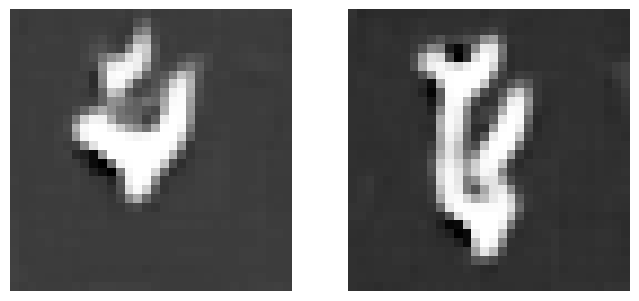

In [45]:
import matplotlib.pyplot as plt

# Number of images to generate
num_generated_images = 2

# Generate images using the trained model
latent_samples = Variable(trainer.G.sample_latent(num_generated_images))
if trainer.use_cuda:
    latent_samples = latent_samples.cuda()

generated_data = trainer.G(latent_samples)

# Remove the extra dimension and convert to numpy array
generated_images = generated_data[:, 0, :, :].data.cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(1, num_generated_images, figsize=(8, 4))

for i in range(num_generated_images):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()


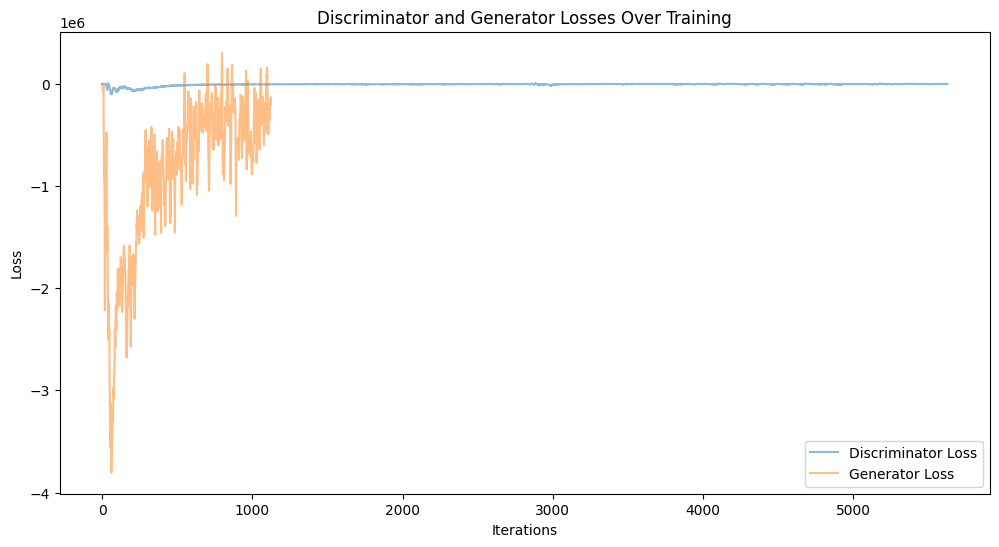

In [34]:

discriminator_loss = [loss.item() for loss in trainer.losses['D']]
generator_loss = [loss.item() for loss in trainer.losses['G']]

plt.figure(figsize=(12, 6))
plt.plot(discriminator_loss, label='Discriminator Loss', alpha=0.5)
plt.plot(generator_loss, label='Generator Loss', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses Over Training')
plt.legend()
plt.show()
